<a href="https://colab.research.google.com/github/Recommendation-System-Project/Recommendation-system/blob/main/DR_coat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time

In [2]:
import pandas as pd
import numpy as np 

from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

## Imputation Error

In [27]:
def loss_emputation(w,y,r,e,p):
  return  ((w*r)**2 - 2*w*y*r + y**2 - e)**2/p

def gradient_descent(w, y, le, observed_e, predicted_r, propensities, max_iter, lr=0.0001):
  w.requires_grad = True
  y.requires_grad = True
  m = observed_e.shape[0]
  theta = [w.item(), y.item()]
  iter_list = []
  loss_list = []
  for i in range(max_iter):
    loss = 0
    rand1 = np.random.randint(0, m, 1)
    r = torch.from_numpy(predicted_r[rand1]).type(torch.float32)
    e = torch.from_numpy(observed_e[rand1]).type(torch.float32)
    p = torch.from_numpy(propensities[rand1]).type(torch.float32)

    output = le(w,y,r,e,p)
    output.backward()
    w.data -= lr * w.grad
    y.data -= lr * y.grad
    w.grad.fill_(0)
    y.grad.fill_(0)

    # for j in range(m):
    #   every_loss = le(w,y,predicted_r[j],observed_e[j],propensities[j]).item()
    #   loss = loss + every_loss
    theta[0] = w.item()
    theta[1] = y.item()
    # print("iter_count: ", i, "the loss: ",loss)
    # print("theta:", theta)
    # iter_list.append(i)
    # loss_list.append(loss)
      
  # plt.plot(iter_list, loss_list)
  # plt.xlabel("iter")
  # plt.ylabel("loss")
  # plt.show()
  # return theta, loss
  for j in range(m):
      every_loss = le(theta[0],theta[1],predicted_r[j],observed_e[j],propensities[j]).item()
      loss = loss + every_loss
  return theta, loss

## Factorization Machine

In [4]:
# FM 特征组合层
class crossLayer(layers.Layer):
    def __init__(self,input_dim, output_dim=10, **kwargs):
        super(crossLayer, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.output_dim = output_dim
        # 定义交叉特征的权重
        self.kernel = self.add_weight(name='kernel', shape=(self.input_dim, self.output_dim), initializer='glorot_uniform',trainable=True)
        
    def call(self, x): # 对照上述公式中的二次项优化公式一起理解
        a = K.pow(K.dot(x, self.kernel), 2)
        b = K.dot(K.pow(x, 2), K.pow(self.kernel, 2))
        return 0.5 * K.mean(a-b, 1, keepdims=True)

# 定义FM模型
def FM(feature_dim, e, p, O_mask):
    inputs = Input(shape=(feature_dim, ))
    
    # 一阶特征
    linear = Dense(units=1, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))(inputs)
    
    # 二阶特征
    cross = crossLayer(feature_dim)(inputs)
    add = Add()([linear, cross])  # 将一阶特征与二阶特征相加构建FM模型
    
    pred = add
    # pred = Activation('sigmoid')(add)
    model = Model(inputs=inputs, outputs=pred)
    
    # model.summary()

    # 以下两段loss定义格式不应更改，keras的loss有且仅有两个参数y_true, y_pred
    def my_coef(y_true, y_pred, predicted_e, propensities, mask):
      error = tf.square(y_true - y_pred)
      error = tf.reshape(error, [290, 300])
      delta = tf.subtract(error, predicted_e)
      a = tf.multiply(mask, delta)
      b = tf.divide(a, propensities)
      return tf.add(predicted_e, b)

    def my_loss_fn(predicted_e, propensities, mask):
      def loss(y_true, y_pred):
        return my_coef(y_true, y_pred, predicted_e, propensities, mask)
      return loss
      
    model.compile(loss=my_loss_fn(predicted_e = e, propensities = p, mask = O_mask),
                  optimizer=optimizers.SGD(), metrics=['accuracy'])

    
    return model    

## Graphic Result

In [23]:
def result(history):
  # list all data in history
  print(history.history.keys())
  print(history.history['val_accuracy'][-1])
  print(history.history['val_loss'][-1])
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## Preparing Data

In [6]:
def get_data():
  observed_r = np.genfromtxt("data/train.ascii", dtype=None) # observed ratings
  observed_r = observed_r.astype('float')
  observed_r[observed_r == 0] = np.nan
    
  predicted_r = np.random.randint(1,5,size=observed_r.shape) # predicted rating
    
  propensities = np.genfromtxt("data/our_propensities.ascii", dtype=None) # propensities for all user item pairs

  O_mask = np.int64(observed_r != np.nan)

  item_features = np.genfromtxt("data/item_features_encoded.ascii", dtype=None)
  user_features = np.genfromtxt("data/user_features.ascii", dtype=None)

  test_r = np.genfromtxt("data/test.ascii", dtype=None) # observed ratings for test
  test_r = observed_r.astype('float')
   
  return observed_r, predicted_r, propensities, O_mask, item_features, user_features

In [7]:
def get_features_matrix(O_mask, user_features, item_features):
  features_matrix = []
  for u in range(O_mask.shape[0]):
    for i in range(O_mask.shape[1]):
      user_f = user_features[u]
      item_f = item_features[i]
      observed = np.concatenate((user_f, item_f))
      features_matrix.append(observed)
  features_matrix = np.array(features_matrix)
  return features_matrix

## Joint Learning

The time of execution of above program is : 0.42833542823791504
theta for imputation error:  [-0.3677859902381897, -1.0848735570907593]
loss for imputation error:  293370.40868064086
Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 dense_27 (Dense)               (None, 1)            36          ['input_28[0][0]']               
                                                                                                  
 cross_layer_27 (crossLayer)    (None, 1)            350         ['input_28[0][0]']               
                                                                                                  
 add_27

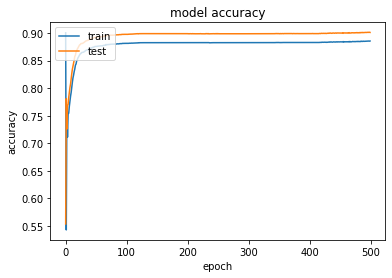

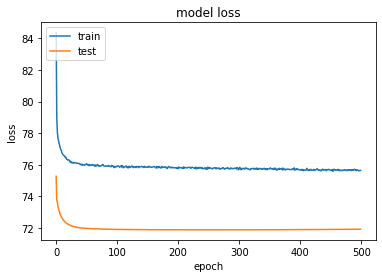

The time of execution of above program is : 0.4476478099822998
theta for imputation error:  [0.09412385523319244, 0.01793309673666954]
loss for imputation error:  665110.4662650017
Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 dense_28 (Dense)               (None, 1)            36          ['input_29[0][0]']               
                                                                                                  
 cross_layer_28 (crossLayer)    (None, 1)            350         ['input_29[0][0]']               
                                                                                                  
 add_28 (

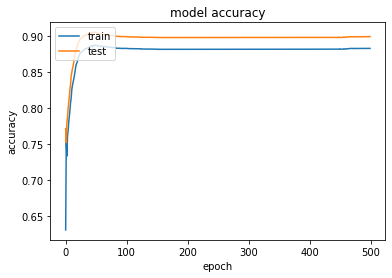

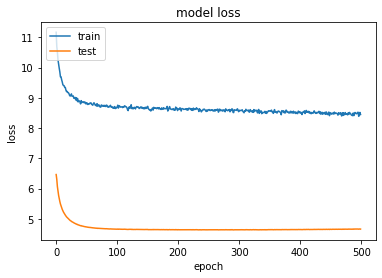

The time of execution of above program is : 0.43700575828552246
theta for imputation error:  [0.2932184338569641, 0.05180816352367401]
loss for imputation error:  672020.7613379182
Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 dense_29 (Dense)               (None, 1)            36          ['input_30[0][0]']               
                                                                                                  
 cross_layer_29 (crossLayer)    (None, 1)            350         ['input_30[0][0]']               
                                                                                                  
 add_29 (

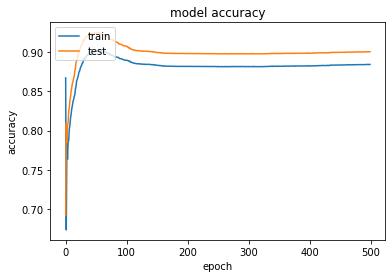

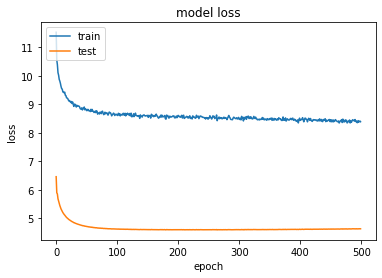

The time of execution of above program is : 0.46247339248657227
theta for imputation error:  [-0.23143643140792847, -0.046282410621643066]
loss for imputation error:  669205.0095044095
Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 dense_30 (Dense)               (None, 1)            36          ['input_31[0][0]']               
                                                                                                  
 cross_layer_30 (crossLayer)    (None, 1)            350         ['input_31[0][0]']               
                                                                                                  
 add_

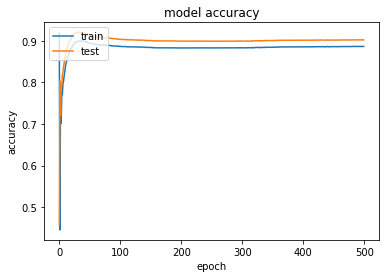

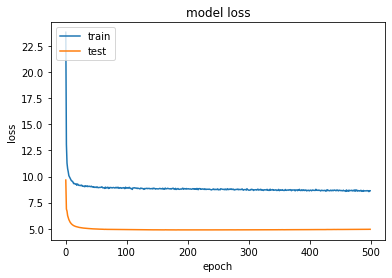

The time of execution of above program is : 0.4502086639404297
theta for imputation error:  [0.4044633209705353, 0.07190313190221786]
loss for imputation error:  663233.4020874884
Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 dense_31 (Dense)               (None, 1)            36          ['input_32[0][0]']               
                                                                                                  
 cross_layer_31 (crossLayer)    (None, 1)            350         ['input_32[0][0]']               
                                                                                                  
 add_31 (A

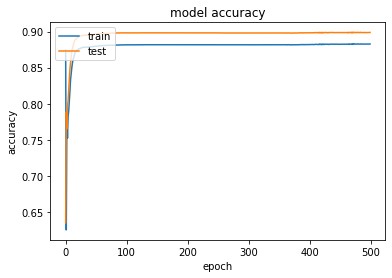

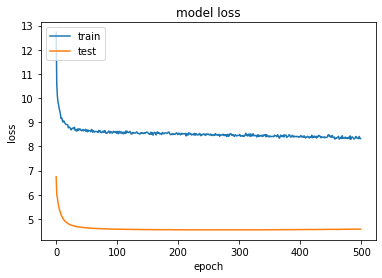

The time of execution of above program is : 0.42601680755615234
theta for imputation error:  [-1.6104671955108643, -0.3047812581062317]
loss for imputation error:  680537.644512468
Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 dense_32 (Dense)               (None, 1)            36          ['input_33[0][0]']               
                                                                                                  
 cross_layer_32 (crossLayer)    (None, 1)            350         ['input_33[0][0]']               
                                                                                                  
 add_32 (

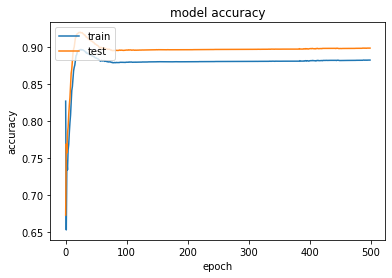

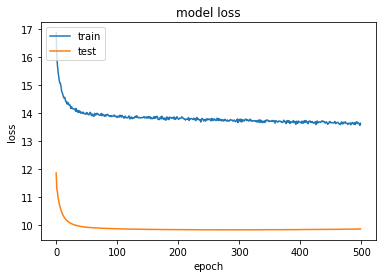

The time of execution of above program is : 0.43865537643432617
theta for imputation error:  [-0.45401689410209656, -0.07710832357406616]
loss for imputation error:  668985.7928219767
Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 dense_33 (Dense)               (None, 1)            36          ['input_34[0][0]']               
                                                                                                  
 cross_layer_33 (crossLayer)    (None, 1)            350         ['input_34[0][0]']               
                                                                                                  
 add_3

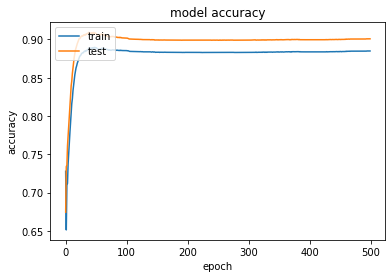

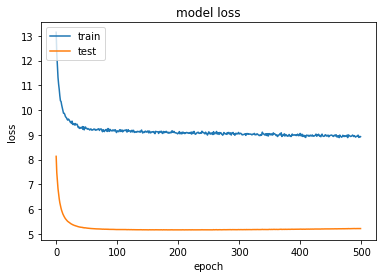

The time of execution of above program is : 0.4372556209564209
theta for imputation error:  [-1.1649761199951172, -0.21437829732894897]
loss for imputation error:  672147.1707353713
Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 dense_34 (Dense)               (None, 1)            36          ['input_35[0][0]']               
                                                                                                  
 cross_layer_34 (crossLayer)    (None, 1)            350         ['input_35[0][0]']               
                                                                                                  
 add_34 

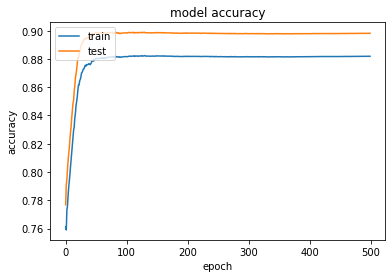

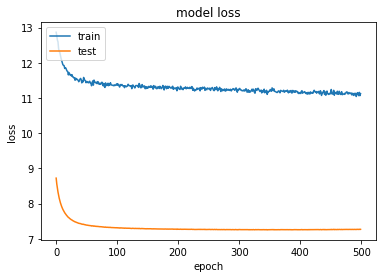

The time of execution of above program is : 0.43683624267578125
theta for imputation error:  [-0.6694586277008057, -0.12695053219795227]
loss for imputation error:  675965.1158395214
Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 dense_35 (Dense)               (None, 1)            36          ['input_36[0][0]']               
                                                                                                  
 cross_layer_35 (crossLayer)    (None, 1)            350         ['input_36[0][0]']               
                                                                                                  
 add_35

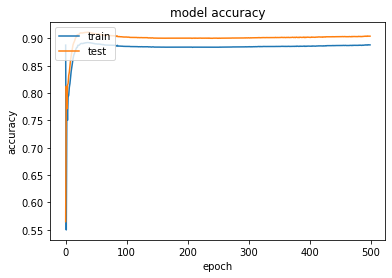

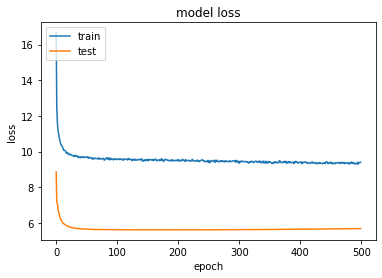

The time of execution of above program is : 0.4635913372039795
theta for imputation error:  [0.32691171765327454, 0.06768721342086792]
loss for imputation error:  660038.9638928314
Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 dense_36 (Dense)               (None, 1)            36          ['input_37[0][0]']               
                                                                                                  
 cross_layer_36 (crossLayer)    (None, 1)            350         ['input_37[0][0]']               
                                                                                                  
 add_36 (

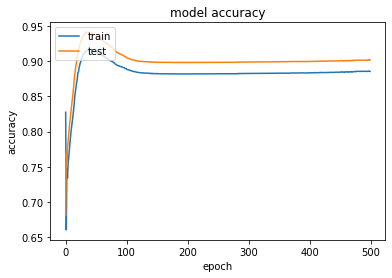

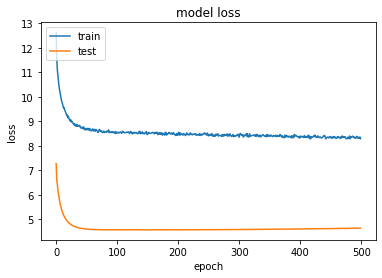

In [28]:
observed_r, predicted_r, propensities, O_mask, item_features, user_features = get_data()
features_matrix = get_features_matrix(O_mask, user_features, item_features)

observed_r_1d = observed_r.flatten()
observed_r_1d = observed_r_1d[~np.isnan(observed_r_1d)]
propensities_1d = np.array(propensities*O_mask).flatten()
propensities_1d = propensities_1d[propensities_1d != 0]
predicted_r_1d = np.array(predicted_r*O_mask).flatten()
predicted_r_1d = predicted_r_1d[predicted_r_1d != 0]

ratings_train = np.genfromtxt("data/train.ascii", dtype=None).astype(np.float32)
ratings_test = np.genfromtxt("data/test.ascii", dtype=None).astype(np.float32)
test_accuracy = 0.5

iter_count = 0
max_iter_joint = 100
while test_accuracy <= 0.95 and iter_count < max_iter_joint:
  observed_e = predicted_r - observed_r # e_ui
  observed_e_1d = observed_e.flatten()
  observed_e_1d = observed_e_1d[~np.isnan(observed_e_1d)]

  # Imputation error
  w = torch.randn(1)
  y = torch.randn(1)
  lr = 0.0001
  max_iter = 1000

  start = time.time()
  theta,loss = gradient_descent(w, y, loss_emputation, observed_e_1d, predicted_r_1d, propensities_1d, max_iter, lr)
  end = time.time()
  print("The time of execution of above program is :", end-start)
  print("theta for imputation error: ", theta)
  print("loss for imputation error: ", loss)

  predicted_e = theta[0]*((predicted_r - theta[1])**2)

  # Training FM
  x_trn = features_matrix
  y_trn = ratings_train.flatten()
  y_tst = ratings_test.flatten()

  # 定义模型
  model = FM(x_trn.shape[1], predicted_e.astype(np.float32), propensities, O_mask.astype(np.float32))

  # 训练模型
  history = model.fit(x_trn, y_trn, epochs=500, batch_size=87000, validation_data=(x_trn, y_tst), verbose = 0)
  predicted_r_1d = model.predict(features_matrix).reshape(87000,)
  predicted_r = predicted_r_1d.reshape(290,300)
  iter_count += 1
  test_accuracy = history.history['val_accuracy'][-1]

  result(history)

In [31]:
predicted_r

array([[0.6166056 , 0.07964272, 0.05710761, ..., 0.17761819, 0.25536513,
        0.17298603],
       [0.62435514, 0.10792574, 0.12559275, ..., 0.20692852, 0.2688603 ,
        0.18440029],
       [0.6252548 , 0.09619501, 0.10582247, ..., 0.21665645, 0.30334693,
        0.19973263],
       ...,
       [0.8707961 , 0.21183753, 0.30371338, ..., 0.0825346 , 0.12402146,
        0.0574186 ],
       [0.87928903, 0.264817  , 0.34738097, ..., 0.12389964, 0.13598777,
        0.07857278],
       [0.87928903, 0.264817  , 0.34738097, ..., 0.12389964, 0.13598777,
        0.07857278]], dtype=float32)

## Things to do
1. lr of imputation

2. max_iter of imputation

3. FM epochs

4. Yahoo

5. MAE MSE DCG 

6. Compare Naive FM without impuation error and IPS




(array([ 1143., 23931., 22368., 25155.,  9046.,  1582.,  1523.,  1335.,
          716.,   201.]),
 array([-0.5368456 , -0.00635719,  0.52413124,  1.0546197 ,  1.5851082 ,
         2.1155965 ,  2.646085  ,  3.1765735 ,  3.7070618 ,  4.2375503 ,
         4.7680387 ], dtype=float32),
 <a list of 10 Patch objects>)

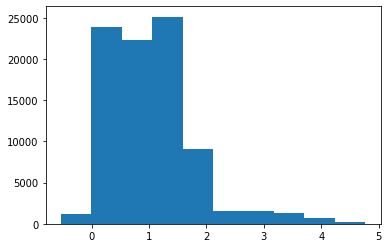

In [32]:
counts, bins = np.histogram(predicted_r*5)
plt.hist(bins[:-1], bins, weights=counts)